### Note : This notebook is inspired from this [example script](https://github.com/Farama-Foundation/HighwayEnv/blob/master/scripts/parking_her.ipynb)

## Setup and imports

In [1]:
import gymnasium as gym
import pprint
from stable_baselines3 import HerReplayBuffer, SAC
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os

from parking_config import *

print(env.spec)
pprint.pprint(env.config)

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EnvSpec(id='parking-v0', entry_point='highway_env.envs:ParkingEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='parking', version=0, additional_wrappers=(), vector_entry_point=None)
{'action': {'type': 'ContinuousAction'},
 'add_walls': True,
 'centering_position': [0.5, 0.5],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'duration': 100,
 'manual_control': False,
 'observation': {'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
                 'normalize': False,
                 'scales': [100, 100, 5, 5, 1, 1],
                 'type': 'KinematicsGoal'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 5,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'scaling': 7,
 'sc

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


In [2]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

# plt.imshow(env.render())
# plt.show()

Action space: Box(-1.0, 1.0, (2,), float32)
Observation space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))


## Train the agent

In [3]:
class FlattenObservation(gym.Wrapper):
    def _init_(self, env: gym.Env):
        super()._init_(env)

    def observation(self, observation: np.ndarray) -> np.ndarray:
        return observation.flatten()

STEPS = 1e4 # 1e5
env_train = FlattenObservation(deepcopy(env))
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
agent = SAC('MultiInputPolicy', env_train, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=0,
            tensorboard_log=os.path.join("test", "train_hrb_sac_3x256"),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            learning_starts=1000,  
            device="cuda")

agent.learn(total_timesteps=int(STEPS))

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(
c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_wrapper_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(
c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do

## Visualise episodes and save video

The two following cells are different implementations of the same objective : create a video and save

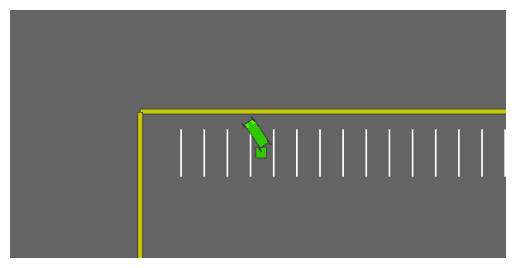

Episode length: -13.690324907182514


In [7]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import gymnasium as gym
import numpy as np
from copy import deepcopy

def run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=True, max_steps=100):
    display_env = deepcopy(env)  # Create a deep copy of the environment for isolated manipulation
    state, _ = display_env.reset()
    frames = []  # Store frames for animation
    rewards = 0
    step = 0
    state_history = []

    done = False
    while not done:
        clear_output(wait=True)
        # Render the frame and store for video creation
        frame = display_env.render()
        frames.append(frame)
        if to_display:
            plt.imshow(frame)
            plt.axis('off')  # Hide axes for clean display
            plt.show()

        # Execute the agent's policy
        action, _ = agent.predict(state, deterministic=True)  # Assuming get_action accepts state and epsilon, adjust if different
        # action = [np.array(action.squeeze(), dtype=np.float32)]
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        step += 1
        if plot_info:
            state_history.append(state)
        if step > max_steps:
            done = True
        

    if to_display:
        print(f'Episode length: {rewards}')

    # If requested to save the video, proceed with saving
    if save_video:
        fig, ax = plt.subplots()
        img_ax = ax.imshow(frames[0])  # Show the first frame
        ax.axis('off')  # Hide axes

        def update(frame):
            img_ax.set_data(frame)  # Update the image displayed

        ani = FuncAnimation(fig, update, frames=frames, repeat=False)

        # Save the animation as MP4
        video_filename = 'parkig_simulation_2.mp4'
        ani.save(video_filename, writer='ffmpeg', fps=10)

        # Optionally display the animation within the notebook
        plt.close(fig)  # Close the figure to prevent it from displaying now
        if to_display:
            video_tag = f'<video src="{video_filename}" width="100%" controls loop autoplay>'
            display(HTML(video_tag))

    if to_display:
        display_env.close()  # Properly close the environment when done

    if plot_info:
        # Plot the heatmap of the state values on average over time 
        state_history = np.array(state_history)
        print(f"State history: {state_history}")
        mean_state_history = np.sum(state_history, axis=0) / state_history.shape[0]
        presence = mean_state_history[:, :, 0]
        # speed = mean_state_history[:, :, 1]
        # lane = mean_state_history[:, :, 2]
        plt.figure(figsize=(15, 5))
        plt.imshow(presence, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('Heatmap of presence')
        plt.show()

# simulate the trained agent and save the video
run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=False, max_steps=200)

### Other tries at creating videos

In [5]:
import gymnasium as gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = "parking-v0"
video_folder = "logs/videos/"
video_length = 100

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")]) # creates the environment in default configuration !!!

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"random-agent-{env_id}")

vec_env.reset()
for _ in range(video_length + 1):
  action, _ = model.predict(obs, deterministic=True)
  action = [np.array(action.squeeze(), dtype=np.float32)]
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()

NameError: name 'model' is not defined

In [ ]:
#@title Visualize a few episodes

import base64
from pathlib import Path

from gymnasium.wrappers import RecordVideo
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()


def record_videos(env, video_folder="videos"):
    wrapped = RecordVideo(
        env, video_folder=video_folder, episode_trigger=lambda e: True
    )

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

N_EPISODES = 10  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable